## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import gc
gc.collect()

0

In [3]:
# External imports
import numpy as np
import cPickle as pickle
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fmin
# Internal imports
import utils
import okcupidio
import linearRegression
import kmeans
import pca
import gaussianModel
import RBFkernel
import sgd
import linearRBF
from linearBinaryClassifier import LinearBinaryClassifier
from linearRandom import LinearRandom
from randomMap import RandomMap
from genericLinear import LinearSGD

In [4]:
from itertools import cycle
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

## Generate Features from OK Cupid Data

In [53]:
# SETTINGS
savename = 'features.p'

In [54]:
# MAKE FEATURES
# Loads data (fairly raw)
data = okcupidio.loadData()
# Preprocess data
okcupidio.processData(data)
# And make binary features out of it
features, featureNames = okcupidio.buildFeatures(data)
# First, replace -1 with nans
features[features == -1] = np.nan
# Save
pickle.dump((features, featureNames), open(savename, 'w'), 2)

orientation multiple choice
sign multiple choice
height int
body_type multiple choice
education multiple choice
ethnicity list
drinks ranked
wants_more_kids multiple choice
likes_cats int
likes_dogs int
has_cats int
religion multiple choice
income int
speaks list
has_kids int
religion_importance ranked
status multiple choice
drugs ranked
last_online date
diet multiple choice
job multiple choice
sex multiple choice
sign_matters multiple choice
age int
smokes multiple choice
has_dogs int
essay9 short response
essay8 short response
essay1 short response
essay0 short response
essay3 short response
essay2 short response
essay5 short response
essay4 short response
essay7 short response
essay6 short response


## Make feature arrays using imputation

In [55]:
# LOAD FEATURES
features, featureNames = pickle.load(open(savename, 'r'))

In [56]:
# Settings
labelsColumn = 'sex_m'
dropData = ['last_online']
minResponseRate = 0.25
nTest = 10000

In [57]:
# Load data
rawDF = pd.DataFrame(data=features, columns=featureNames)
pickle.dump(rawDF, open('rawdf.p','w'), 2)

# drop unwanted data
for drop in dropData:
    
    rawDF.drop(drop, 1, inplace=True)
    
# Ignore data with response rates too low
# columns = df.columns[df.columns != labelsColumn]
columns = rawDF.columns
for col in columns:
    
    if rawDF[col].notnull().mean() < minResponseRate:
        
        rawDF.drop(col, 1, inplace=True)
        


In [58]:
# IMPUTATION
# (replace missing data, except for in the labelsColumn)
imputedDF = rawDF.copy()
columns = imputedDF.columns[imputedDF.columns != labelsColumn]
for col in columns:
    series = imputedDF[col]
    nChoice = series.isnull().sum()
    if nChoice > 0:
        notnulls = series[series.notnull()]
#         vals = np.random.choice(notnulls, nChoice)
        vals = notnulls.mean() * np.ones(nChoice)
        series[series.isnull()] = vals
        imputedDF[col] = series

In [59]:
# Now remove people without reported values in the labels Column
df = imputedDF[imputedDF[labelsColumn].notnull()]
filteredDF = rawDF[imputedDF[labelsColumn].notnull()]
# Ignore entries where stddev == 0
columns = df.columns[df.columns != labelsColumn]
for col in columns:
    if df[col].std() == 0:
        print 'dropping: ', col
        df.drop(col, 1, inplace=True)
        filteredDF.drop(col, 1, inplace=True)
        
pickle.dump(df, open('imputed_df.p', 'w'), 2)
pickle.dump(filteredDF, open('filtered_df.p', 'w'), 2)

In [60]:
# Get arrays from the data frame
dfShort = df.drop(labelsColumn, 1)
x = dfShort.values
names = dfShort.columns.values
y = df[labelsColumn].values
# And save
pickle.dump((x, y, names), open('dataset.p', 'w'), 2)

In [61]:
# NOW SPLIT the dataset
y = y.reshape([len(y), 1])
nTrain = len(x) - nTest
np.random.seed(0)
ind = np.random.rand(len(x)).argsort()
trainInd = ind[0:nTrain]
testInd = ind[nTrain:]
xtrain, ytrain = (x[trainInd], y[trainInd])
xtest, ytest = (x[testInd], y[testInd])
# And condition it
xtrain, center, scale = utils.condition(xtrain)
xtest, center, scale = utils.condition(xtest, center, scale)

# save the split set
pickle.dump((xtrain, ytrain, trainInd), open('data_train.p', 'w'), 2)
pickle.dump((xtest, ytest, testInd), open('data_test.p','w'), 2)

## Load Data

In [6]:
# load data if necessary:
df = pickle.load(open('imputed_df.p', 'r'))
rawDF = pickle.load(open('rawdf.p'))
x, y, names = pickle.load(open('dataset.p'))
xtrain, ytrain, trainInd = pickle.load(open('data_train.p', 'r'))
xtest, ytest, testInd = pickle.load(open('data_test.p', 'r'))

In [5]:
print xtrain.shape
print xtest.shape

(49946, 217)
(10000, 217)


## Linear regression

### Un-boosted

In [7]:
lr = linearRegression.BinaryLinearRegression(regScale=1e1)
lr.fit(xtrain, ytrain)
ypred = lr.pred(xtrain)
wrong = (ypred != ytrain).astype(float)
print "0/1 loss:", wrong.mean()
print "mean confidence:", lr.confidence(xtrain).mean()
pickle.dump((lr.w, lr.w0, names), open('regression_results.p','w'), 2)

0/1 loss: 0.112361350258
mean confidence: 0.836473337095


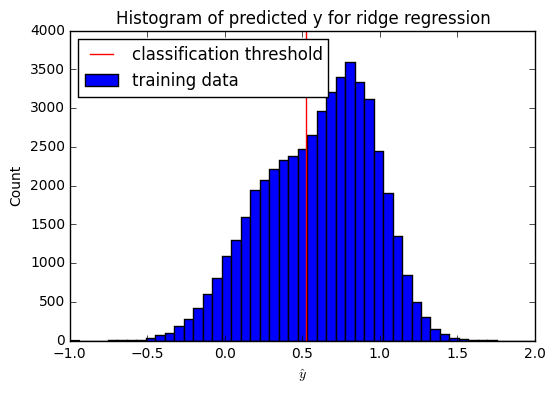

In [28]:
yclass = lr.pred(xtrain)
w = lr.w
w0 = lr.w0
ypred = np.dot(xtrain, w) + w0
ybins = np.linspace(-1, 2, 50)
plt.hist(ypred, ybins);
plt.vlines(lr.classifier.threshold, 0, plt.ylim()[1], 'r')
plt.ylabel('Count')
plt.title('Histogram of predicted y for ridge regression')
plt.xlabel(r'$\hat{y}$')
plt.legend(['classification threshold', 'training data'], loc='best')
plt.savefig('figures/linear_ypred_histogram.pdf')

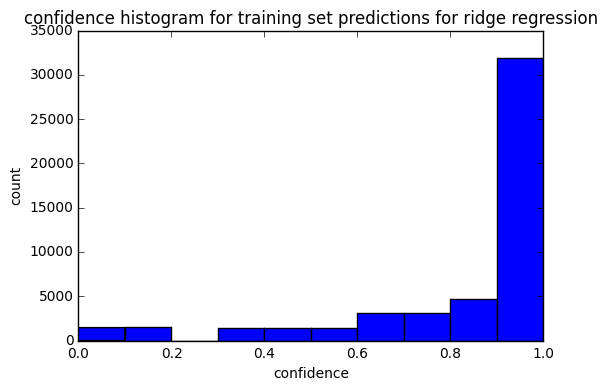

In [38]:
confidence = lr.confidence(xtrain)
plt.hist(confidence, 10);
plt.ylabel('count')
plt.xlabel('confidence')
plt.title('confidence histogram for training set predictions for ridge regression')
plt.savefig('figures/ridge_confidence.pdf')

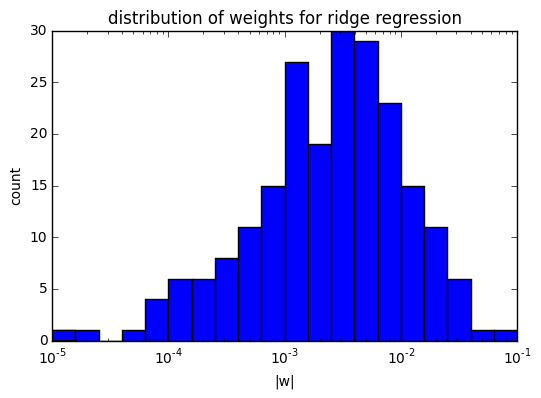

In [31]:
nbins = 20
bins = np.logspace(-5, -1, nbins+1)
plt.hist(abs(lr.w), bins);
plt.gca().set_xscale('log')
plt.title('distribution of weights for ridge regression')
plt.ylabel('count')
plt.xlabel('|w|')
plt.savefig('figures/ridge_regression_weights.pdf')

In [10]:
wInd = abs(lr.w.flatten()).argsort()
# print names[wInd[0:30]]
df2 = dfShort.filter(like='speaks')
a = df2.sum()
a.sort()
print a/a.sum()

NameError: name 'dfShort' is not defined

### L2 boost

In [7]:
def evalPredictors(predictors, x, nu=0.5):
    pred = predictors[0](x)
    for predictor in predictors[1:]:
        pred += nu*predictor(x)
    return pred

In [8]:
# dataWeights = np.ones([len(xtrain), 1])

ymean = ytrain.mean()
nu = 0.5
boostPredictors = [lambda x : np.zeros([len(x), 1])]

for i in range(10):
    ypred = evalPredictors(boostPredictors, xtrain, nu)
    residuals = ytrain - ypred
    print (residuals**2).mean()
    lrBoost = linearRegression.BinaryLinearRegression(regScale=1e0, classify=False, scalarOffset=True)
    lrBoost.fit(xtrain, residuals) 
    boostPredictors.append(lrBoost.ypred)

0.597345132743
0.230710322316
0.139050864147
0.116135810708
0.110407000122
0.108974785668
0.108616729103
0.108527214224
0.108504835319
0.108499240547


In [9]:
from linearBinaryClassifier import LinearBinaryClassifier

ypred = evalPredictors(boostPredictors, xtrain, nu)
boostClassifier = LinearBinaryClassifier(ytrain, ypred)

def boostPred(x):
    ypred = evalPredictors(boostPredictors, x, nu)
    yclass = boostClassifier.classify(ypred)
    confidence = boostClassifier.confidence(ypred)
    return (2 * yclass - 1) * confidence

#### Most male traits

In [14]:
ind = (-lr.w[:,0]).argsort()
for i in range(10):
    j = ind[i]
    print i,',', names[j],',', lr.w[j,0]

0 , height , 0.279118980281
1 , body_type_athletic , 0.0423049284121
2 , job_computer / hardware / software , 0.0353019759313
3 , orientation_gay , 0.0260456026253
4 , ethnicity_hispanic / latin , 0.0237886462659
5 , job_science / tech / engineering , 0.0215516986064
6 , ethnicity_asian , 0.0190760877008
7 , job_construction / craftsmanship , 0.0174278961617
8 , education_graduated from high school , 0.0163022698625
9 , body_type_fit , 0.0157394454867


#### Most female traits

In [16]:
ind = (lr.w[:,0]).argsort()
for i in range(10):
    j = ind[i]
    print i,',', names[j],',', abs(lr.w[j,0])

0 , body_type_curvy , 0.070797306793
1 , ethnicity_white , 0.0396973974824
2 , body_type_full figured , 0.0345614407715
3 , orientation_bisexual , 0.0307447069283
4 , has_cats , 0.0286279967904
5 , job_medicine / health , 0.0221053124697
6 , body_type_thin , 0.0217519286954
7 , job_education / academia , 0.0200326446361
8 , education_graduated from masters program , 0.0190705382787
9 , has_dogs , 0.0182778669229


#### Overall best predictors

In [25]:
absW = abs(lr.w[:, 0])
ind = (-absW).argsort()
for i in range(10):
    j = ind[i]
    print i,',', names[j],',', lr.w[j,0]

0 , height , 0.279118980281
1 , body_type_curvy , -0.070797306793
2 , body_type_athletic , 0.0423049284121
3 , ethnicity_white , -0.0396973974824
4 , job_computer / hardware / software , 0.0353019759313
5 , body_type_full figured , -0.0345614407715
6 , orientation_bisexual , -0.0307447069283
7 , has_cats , -0.0286279967904
8 , orientation_gay , 0.0260456026253
9 , ethnicity_hispanic / latin , 0.0237886462659


#### Overall worst predictors

In [24]:
absW = abs(lr.w[:, 0])
ind = (absW).argsort()
for i in range(10):
    j = ind[i]
    print i,',', names[j],',', absW[j]

 0 , speaks_latvian , 1.09710062992e-09
1 , speaks_serbian , 1.16382962023e-05
2 , education_ph.d program , 2.13281682121e-05
3 , sign_taurus , 5.53266859017e-05
4 , speaks_lisp , 7.65594214695e-05
5 , speaks_georgian , 8.14712085875e-05
6 , education_law school , 8.25810210317e-05
7 , diet_strictly halal , 9.42571421528e-05
8 , diet_mostly halal , 0.000104942468097
9 , speaks_catalan , 0.000106935015331


## K-means

In [10]:
# Perform PCA
nKeepKmeans = 25
w, vkmeans = pca.PCA(xtrain)
xa = pca.proj(xtrain, vkmeans, nKeepKmeans)
# x0 = xa[ytrain.flatten() == 0]
# x1 = xa[ytrain.flatten() == 1]
xatest = pca.proj(xtest, vkmeans, nKeepKmeans)

Sum of eigenvalues (direct): 217
Sum of eigenvalues (from xTx): 217


In [11]:
# Perform kmeans
km = kmeans.kmeans(xa, nCluster=256, xtol=.1)
km.fit()
km.labelClusters(ytrain)
ypred = km.pred(xa)
wrong = (ypred != ytrain).flatten()
print "0/1 loss:", wrong.mean()

kmSaveDict = {'centroids': km.centroids, 'clusterNames': km.clusterNames}
pickle.dump(kmSaveDict, open('kmeans.p', 'w'), 2)

(max centroid change, error):  13.7231319853 16.7071965234
(max centroid change, error):  8.75086783791 14.9958528168
(max centroid change, error):  20.832168804 14.1344679072
(max centroid change, error):  1.63523318979 13.9572946921
(max centroid change, error):  1.49556144829 13.854738963
(max centroid change, error):  0.683930843601 13.7743929113
(max centroid change, error):  0.795740256254 13.697082634
(max centroid change, error):  0.860918969355 13.6300957898
(max centroid change, error):  1.92803045467 13.5817950946
(max centroid change, error):  0.389301446465 13.5524587269
(max centroid change, error):  0.560388002662 13.5261387972
(max centroid change, error):  0.555890450148 13.5031079756
(max centroid change, error):  0.51242976908 13.4821934251
(max centroid change, error):  1.18707893024 13.451203539
(max centroid change, error):  2.1025547238 13.3779859986
(max centroid change, error):  1.01729753764 13.352981102
(max centroid change, error):  0.727822093976 13.3394839

## Gaussian Model

In [7]:
# Perform PCA
nKeepGauss = 20
w, vgaussian = pca.PCA(xtrain)
xa = pca.proj(xtrain, vgaussian, nKeepGauss)
# x0 = xa[ytrain.flatten() == 0]
# x1 = xa[ytrain.flatten() == 1]
xatest = pca.proj(xtest, vgaussian, nKeepGauss)

Sum of eigenvalues (direct): 217
Sum of eigenvalues (from xTx): 217


In [15]:
error = pca.reconstructionError(w)
print error[20]
print w[0]/w[20]

0.829109146691
2.1014655913


In [13]:
# "train" the model
gm = gaussianModel.GaussianModel()
gm.fit(xa, ytrain)
(gm.pred(xa) != ytrain).mean()

0.31572097865694948

## Logstic regression

In [14]:
dataWeights = None
logistic = LinearSGD(xtrain, ytrain, learningRateScale=1e-1, lossScheme='softmax', miniBatchSize=100, tau0=int(1e5), kappa=0.55)
logistic.fit(maxIter=30, ftol=1e-6, dataWeights=dataWeights)


training loss: 1.38779317775e-05
training 0/1 loss: 0.597345132743

Step:  1
training loss: 5.69740151332e-06
training 0/1 loss: 0.113222280062

Step:  2
training loss: 5.62328731124e-06
training 0/1 loss: 0.111800744804

Step:  3
training loss: 5.60234679887e-06
training 0/1 loss: 0.111840788051

Step:  4
training loss: 5.60386409594e-06
training 0/1 loss: 0.111780723181

Step:  5
training loss: 5.59551270014e-06
training 0/1 loss: 0.111940896168

Step:  6
training loss: 5.59210328554e-06
training 0/1 loss: 0.111980939415

Step:  7
training loss: 5.59446657196e-06
training 0/1 loss: 0.111640571818

Step:  8
training loss: 5.58973415197e-06
training 0/1 loss: 0.111820766428

Step:  9
training loss: 5.58856313666e-06
training 0/1 loss: 0.111039923117

Step:  10
training loss: 5.58462263748e-06
training 0/1 loss: 0.111480398831

Step:  11
training loss: 5.58213775187e-06
training 0/1 loss: 0.111280182597

Step:  12
training loss: 5.58162792623e-06
training 0/1 loss: 0.111320225844

Step:

## RBF Kernel softmax

In [43]:
rbf = linearRBF.LinearRBF(xtrain, ytrain, miniBatchSize=30, learningRateScale=5e-4, lossScheme='softmax', \
                          kappa=0.55, tau0=int(1e5), arrayBatchSize=100)

In [44]:
try:
    rbf.fit(maxIter=30)
finally:
    pickle.dump(rbf, open('rbf_results.p', 'w'), 2)

training loss: 1.38779317775e-05
training 0/1 loss: 0.597345132743

Step:  1
training loss: 8.17325957682e-06
training 0/1 loss: 0.185019821407

Step:  2
training loss: 7.9036031091e-06
training 0/1 loss: 0.174908901614

Step:  3
training loss: 7.98776293697e-06
training 0/1 loss: 0.179373723622

Step:  4
training loss: 7.84598965336e-06
training 0/1 loss: 0.173867777199

Step:  5
training loss: 7.85084936733e-06
training 0/1 loss: 0.171805549994

Step:  6
training loss: 8.20969761747e-06
training 0/1 loss: 0.171405117527

Converged


## Linear Random Map

In [45]:
lrm = LinearRandom(xtrain, ytrain, lossScheme='softmax', learningRateScale=5e-4, regScale=0., miniBatchSize=50, \
                  tau0=int(1e5), kappa=0.55, nRandFeatures=len(xtrain))
try:
    lrm.fit(maxIter=30)
finally:
    pickle.dump(lrm, open('lrm_results.p', 'w'), 2)

training loss: 1.38779317775e-05
training 0/1 loss: 0.597345132743

Step:  1
training loss: 9.70771235129e-06
training 0/1 loss: 0.143394866456

Step:  2
training loss: 1.62641941579e-05
training 0/1 loss: 0.187622632443

Step:  3
training loss: 8.52411012296e-06
training 0/1 loss: 0.133203860169

Step:  4
training loss: 8.70135592308e-06
training 0/1 loss: 0.135085892764

Step:  5
training loss: 8.41940539284e-06
training 0/1 loss: 0.133344011532

Step:  6
training loss: 9.08421585117e-06
training 0/1 loss: 0.142674088015

Converged


## Ensemble Predictions

In [15]:
# Load results
rbf = pickle.load(open('rbf_results.p','r'))
lrm = pickle.load(open('lrm_results.p','r'))
# kmSaveDict = pickle.load(open('kmeans.p', 'r'))

In [16]:
def softmaxProb(x, w):
    """
    For binary softmax (eg logistic) gives probablity of x being in class 1 given w.
    """
    N, m = w.shape
    k = m + 1
    E = np.exp(np.dot(x, w))
    A = 1./(1 + E.sum(1))
    A = utils.columnVector(A)    
    P = np.dot(A, np.ones([1, k]))    
    P[:, 0:-1] *= E
    
    return P[:, 1, None]

In [17]:
def kernelizedSoftmaxProb(x, w, featureMap, batchsize=100):
    """
    """
    P = np.zeros([len(x), 1])
    for slicer in utils.arrayBatch(x, batchsize):
        h = featureMap(x[slicer])
        P[slicer] = softmaxProb(h, w)
    return P


### Set up predictors

In [18]:
def predictor_kmeans(x):
    x = pca.proj(x,vkmeans, nKeepKmeans)
    kmPred = km.pred(x)
    kmConf = (2 * km.confidence(x) - 1)
    kmPred = (2 * kmPred - 1) * kmConf
    return kmPred
def predictor_gm(x):
    x = pca.proj(x, vgaussian, nKeepGauss)
    gmPred = gm.pred(x)
    gmConf = 2 * gm.confidence(x) - 1
    gmPred = (2 * gmPred - 1) * gmConf
    return gmPred
def predictor_lin(x):
    linPred = lr.pred(x)
    linConf = lr.confidence(x)
    linPred = (2 * linPred - 1) * linConf
    return linPred
def predictor_log(x):
    logPred = 2 * softmaxProb(logistic.featureMap(x), logistic.sgd.w) - 1
    return logPred
def predictor_lrm(x):
    return 2 * kernelizedSoftmaxProb(x, lrm.results['w'], lrm.featureMap) - 1
def predictor_rbf(x):
    return 2 * kernelizedSoftmaxProb(x, rbf.results['w'], rbf.featureMap) - 1
predFuncs = {'kmeans': predictor_kmeans,
            'gm': predictor_gm,
            'lin': predictor_lin,
            'log': predictor_log,
            'lrm': predictor_lrm,
            'rbf': predictor_rbf}

In [49]:
# Training predictions
predictions = {}
for name, predFunc in predFuncs.iteritems():
    print 'Calculating prediction for: ', name
    predictions[name] = predFunc(xtrain)
pickle.dump(predictions, open('predictions_train.p', 'w'))

Calculating prediction for:  log
Calculating prediction for:  lin
Calculating prediction for:  lrm
Calculating prediction for:  kmeans
Calculating prediction for:  rbf
Calculating prediction for:  gm


In [19]:
# Load the predictions
predictions = pickle.load(open('predictions_train.p'))
forestPredTrain, forestPredTest = pickle.load(open('forest_predictions.p','r'))
predictions['random forest'] = forestPredTrain
predictions['l2boost'] = boostPred(xtrain)

In [20]:
predictorNames = sorted(predictions.keys())
allPred = [predictions[key].T for key in predictorNames]
allPred = np.concatenate(allPred).T

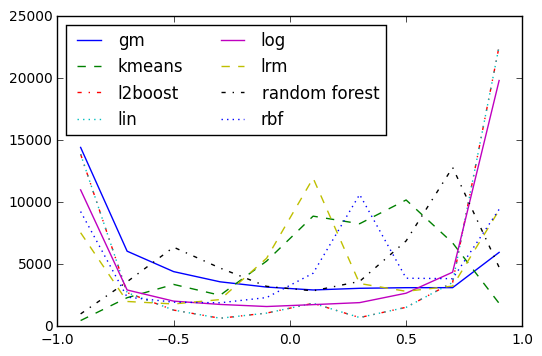

In [23]:
bins = np.linspace(-1, 1, 11)
bincenters = (bins[1:] + bins[0:-1])/2.
for p in allPred.T:
    N, dummy = np.histogram(p, bins)
    plt.plot(bincenters, N, next(linecycler))
plt.legend(predictorNames, ncol=2, loc='best');
plt.savefig('figures/confidence_dist.pdf')

### Find best predictor weights

In [75]:
def multiPredictor(w, predictions):
    w = abs(w)
    predval = (predictions * w).sum(1)
    ypred = np.zeros([len(predval), 1])
    ypred[predval > 0] = 1
    return ypred

def multiPredictorLoss(w, predictions=allPred, regularization=1, y=ytrain):
    ypred = multiPredictor(w, predictions)
#     print ypred.shape, y.shape
    L = (ypred != y).mean() + regularization * (w**2).sum()
    return L

#### Fit predictor weights to y in [-1, 1]

In [81]:
# Find function weights that minimize the loss
allPredictorWeights = []
losses = []
for i in range(25):
    output = fmin(multiPredictorLoss, np.random.rand(len(predictorNames)), full_output=True)
    allPredictorWeights.append(abs(output[0]))
    losses.append(output[1])
    
ind = np.argmin(losses)
predictorWeights = allPredictorWeights[ind]
print ''
print 'Predictor weights: '
ind = np.argsort((-predictorWeights))
for i in ind:
    print predictorNames[i], '\t', predictorWeights[i]
    
bestLoss = multiPredictorLoss(predictorWeights, regularization=0.)
print 'unregularized loss: ', bestLoss
pickle.dump(predictorWeights, open('predictor_weights.p', 'w'), 2)

Optimization terminated successfully.
         Current function value: 0.108874
         Iterations: 388
         Function evaluations: 621
Optimization terminated successfully.
         Current function value: 0.217394
         Iterations: 306
         Function evaluations: 509
Optimization terminated successfully.
         Current function value: 0.125815
         Iterations: 387
         Function evaluations: 598
Optimization terminated successfully.
         Current function value: 0.108572
         Iterations: 600
         Function evaluations: 910
Optimization terminated successfully.
         Current function value: 0.134233
         Iterations: 301
         Function evaluations: 487
Optimization terminated successfully.
         Current function value: 0.124719
         Iterations: 712
         Function evaluations: 1048
Optimization terminated successfully.
         Current function value: 0.137863
         Iterations: 391
         Function evaluations: 611
Optimization termin

In [110]:
ind = np.argsort((-predictorWeights))
norm = np.sum(predictorWeights)
for i in ind:
    print predictorWeights[i]/norm
for i in ind:
    print predictorNames[i]

0.519707830724
0.13739074133
0.128585419229
0.0796243145283
0.0600132401639
0.0523003314443
0.0160408728946
0.00633724968567
random forest
rbf
kmeans
l2boost
lrm
lin
log
gm


In [23]:
predictorWeights = pickle.load(open('predictor_weights.p', 'r'))

#### Test

In [24]:
# Test predictions
testPredictions = {}
for name, predFunc in predFuncs.iteritems():
    print 'Calculating prediction for: ', name
    testPredictions[name] = predFunc(xtest)
pickle.dump(testPredictions, open('predictions_test.p', 'w'))

Calculating prediction for:  log
Calculating prediction for:  lin
Calculating prediction for:  lrm
Calculating prediction for:  kmeans
Calculating prediction for:  rbf
Calculating prediction for:  gm


In [29]:
# OR LOAD TEST PREDICTIONS
testPredictions = pickle.load(open('predictions_test.p', 'r'))
testPredictions['random forest'] = forestPredTest
testPredictions['l2boost'] = boostPred(xtest)

In [82]:
allTestPred = [testPredictions[key].T for key in predictorNames]
allTestPred = np.concatenate(allTestPred).T
testLoss = multiPredictorLoss(predictorWeights, allTestPred, regularization=0., y=ytest)

In [83]:
print testLoss

0.1162


### Echo losses

In [43]:
print 'Training 0/1 loss\n'
for i, name in enumerate(predictorNames):
    ypred = allPred[:, i, None] > 0
    print (ypred != ytrain).mean()
for i, name in enumerate(predictorNames):
    print name

Training 0/1 loss

0.31556080567
0.300844912506
0.112661674609
0.112581588115
0.111680615064
0.142674088015
0.116405718176
0.171405117527
gm
kmeans
l2boost
lin
log
lrm
random forest
rbf


In [44]:
print 'Test 0/1 loss\n'
for i, name in enumerate(predictorNames):
    ypred = allTestPred[:, i, None] > 0
    print (ypred != ytest).mean()
    
for i, name in enumerate(predictorNames):
    print name

Test 0/1 loss

0.3161
0.3072
0.1188
0.1188
0.119
0.1561
0.1276
0.1846
gm
kmeans
l2boost
lin
log
lrm
random forest
rbf


### Success analysis

In [96]:
responseRate = rawDF.notnull().mean(1).values
responseRateTrain = responseRate[trainInd]
responseRateTest = responseRate[testInd]
successTest = (multiPredictor(predictorWeights, allTestPred) == ytest).flatten()
successTrain = (multiPredictor(predictorWeights, allPred) == ytrain).flatten()

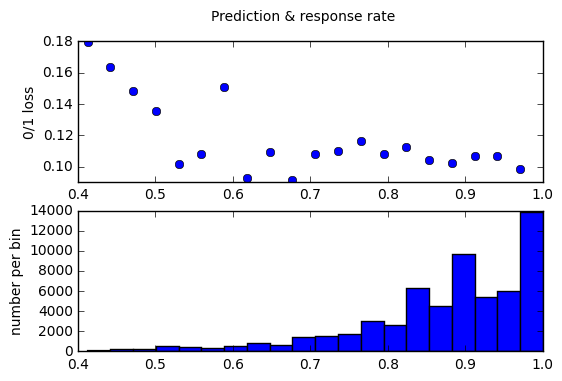

In [108]:
nbins = 20
hist, bins = np.histogram(responseRate, bins=nbins)
ind = np.digitize(responseRateTrain, bins) - 1
ind[ind >= nbins] = nbins -1
mean = np.zeros(nbins) * np.nan
for i in range(nbins):
    mask = (ind == i)
    if np.any(mask):
        mean[i] = successTrain[mask].mean()
        
plt.suptitle('Prediction & response rate')
plt.subplot(2, 1, 1)
plt.plot(bins[0:-1], 1-mean,'o')
plt.ylabel('0/1 loss')
plt.subplot(2, 1, 2)
plt.hist(responseRate, bins);
plt.ylabel('number per bin')

plt.savefig('figures/prediction_response_rate.pdf')